# Image classification with a neutral atom quantum processor

We propose here a protocol to perform image classification using the neutral atoms QPUs developped by PASQAL. Rubidium atoms can be trapped at specific positions in 2D inside a vaccum chamber. The electronic states of the atoms can be controlled by laser pulses, and the global system will behave in an intractable dynamic. The implementation is inspired by a previous work of [Henry, Thabet et al.](https://arxiv.org/pdf/2107.03247.pdf) who proposed an algorithm for performing graph classification on such a device.

The algorithm we propose comes from the idea that an image can be assimilated to a regular grid-shape graph. It is composed of four steps:
- 1. Preprocessing of the image
- 2. Encoding of the imgage into a quantum state
- 3. Application of a parameterized circuit
- 4. Measurement and output of the probability of defect

Each step is detailed below
![General pipeline of our algorithm](general_figure.jpg)

### Preprocessing of the image

The images are currently too large to be entirely processed on a quantum computer. Therefore, one must use dimension reduction techniques. We employ here a local averaging of the pixels. Methods like Principal Components Analysis intend to maximize the information retained and require low computation resources, but imply a loss of the grid geometry. As a future exploration, we may also use the output of a pretrained Convolutional Neural Network, and train a supplementary layer jointly with the rest of the circuit, as proposed by [Mari, Bromley et al.](https://arxiv.org/abs/1912.08278)

### Encoding of the features

Our algorithm starts with a grid register of atoms. On each atom, we apply a pulse which duration will depend of the value of the corresponding extracted feature. The main drawback of this part is the delay for changing the target of the laser due to the constraint of the hardware.
Our system is then in a state 
$$
|\psi(image)\rangle
$$

![Pulse sequence](pulses.jpeg)

### Parameterized sequence of pulses

After the encoding of the image, we apply a parameterized unitary composed of a succession of global pulses on the system. Concretely the parameters are the duration and/or amplitude of global pulses. Our system is then in the state
$$
|\Psi(image ; \theta)\rangle = U(\theta)|\psi(image)\rangle.
$$
$\theta$ is the vector of parameters to be trained.

### Measurement and output of the probability of defect

The probability of defect is obtained by measuring an observable on the state $|\Psi(image ; \theta)\rangle$ and applying a sigmoid function.
We have 
$$
p_{defect} = \sigma(\langle \Psi(image ; \theta)|O|\Psi(image ; \theta)\rangle)
$$

where $O = \frac{1}{N} \sum_{i=1}^{N}Z_i$ and $\sigma(x) = \frac{e^x}{1 + e^x}$.

The parameters $\theta$ are finally trained by minimizing the binary crossentropy across the training set. The optimization is performed by Bayesian optimization.

We present below an implementation using [Pulser](https://pulser.readthedocs.io/en/stable/), an open-source library for simulating computation on neutral atoms devices developed by Pasqal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import load_dataset, preprocess_images, cost, probas_pred, labels_pred, accuracy
from time import time
from skopt import gp_minimize

Loading and preprocessing the dataset

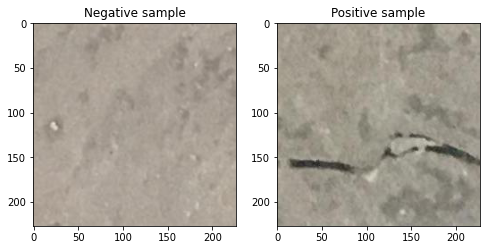

In [2]:
n_samples = 20
neg_images, pos_images = load_dataset(n_samples)

images = np.concatenate([neg_images, pos_images], axis=0)
targets = np.concatenate([np.zeros(n_samples), np.ones(n_samples)], axis=0)
np.random.seed(43)
permutation = np.random.permutation(len(targets))
images = images[permutation]
targets = targets[permutation]

N_train = int(np.floor(.8 * len(targets)))
images_train, targets_train = images[0:N_train], targets[0:N_train]
images_test, targets_test = images[N_train::], targets[N_train::]

plt.figure(figsize=[8, 16])
plt.subplot(121)
plt.imshow(neg_images[0])
plt.title('Negative sample')
plt.subplot(122)
plt.imshow(pos_images[0])
plt.title('Positive sample')
plt.show()

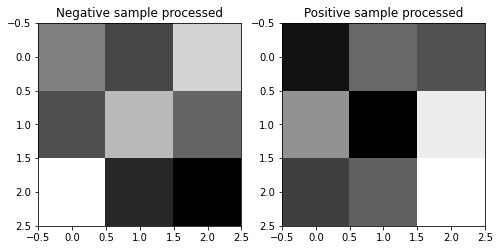

In [3]:
images_train_processed = preprocess_images(images_train)
images_test_processed = preprocess_images(images_test)

plt.figure(figsize=[8, 16])
plt.subplot(121)
plt.imshow(preprocess_images([neg_images[0]])[0], cmap='binary')
plt.title('Negative sample processed')
plt.subplot(122)
plt.imshow(preprocess_images([pos_images[0]])[0], cmap='binary')
plt.title('Positive sample processed')
plt.show()

Training of the parameters (this might take a few minutes to run)

In [4]:
import warnings
warnings.filterwarnings('ignore')

def get_score(param):
    middle = len(param)//2
    times = param[0:middle]
    pulses = param[middle::]
    return cost(images_train_processed, targets_train, times, pulses)

bounds = [(0.02, 2.)] * 3 + [(0.02, .5)] * 3

opt_result = gp_minimize(
    get_score,
    bounds,
    acq_func='LCB',
    n_calls=10,
    n_initial_points=5,
    acq_optimizer='sampling',
    n_points=5000,
    kappa=4,
    n_jobs=-1)


Testing

In [5]:
middle = len(opt_result.x)//2
times = opt_result.x[0:middle]
pulses = opt_result.x[middle::]

preds = probas_pred(images_test_processed, times, pulses)
preds = labels_pred(preds)

acc = accuracy(preds, targets_test)

print("The accuracy on the test set is: ", acc)

The accuracy on the test set is:  0.625


### Future steps

We presented here the backbone of our project, and as a second step we will be looking towards the following directions:

- Perform a training on the real BMW dataset
- Explore variations of each steps: using a CNN as a feature extractor, different encoding strategies, different sizes of parameterized circuits, different observables, kernel methods as in the original work
- Hardware implementation or simulation on a HPC platform